In [1]:
#importing necessary libraries
from api.mapbox_api_cycling import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod
from collections import defaultdict
from shapely.ops import unary_union

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
censusTracts.shape

(869, 63)

In [4]:
branchInfo.loc[branchInfo['BRANCH'] == 'Roosevelt']

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
60,Roosevelt,,1101 W. Taylor Street,Chicago,IL,60607,,,"(41.86943838326072, -87.6544586134924)",1,None


In [5]:
branchInfo = branchInfo.drop([60,60])
branchInfo = branchInfo.set_index('BRANCH')
branchInfo = branchInfo.reset_index()
branchInfo

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
0,Albany Park,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",3401 W. Foster Ave.,Chicago,IL,60625,(773) 539-5450,https://www.chipublib.org/locations/3/,"(41.97557881655979, -87.71361314512697)",0,None
1,Altgeld,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",955 E. 131st Street,Chicago,IL,60827,(312) 747-3270,https://www.chipublib.org/locations/4/,"(41.65719847558056, -87.59883829075173)",0,None
2,Archer Heights,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5055 S. Archer Ave.,Chicago,IL,60632,(312) 747-9241,https://www.chipublib.org/locations/5/,"(41.80110836194246, -87.72648385568911)",0,None
3,Austin,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5615 W. Race Ave.,Chicago,IL,60644,(312) 746-5038,https://www.chipublib.org/locations/6/,"(41.88917312206642, -87.7658203582574)",0,None
4,Austin-Irving,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",6100 W. Irving Park Rd.,Chicago,IL,60634,(312) 744-6222,https://www.chipublib.org/locations/7/,"(41.95312267684315, -87.77928489355646)",0,None
...,...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"Mon. & Wed., Noon-8; Tue. & Thu., 10-6; Fri. &...",830 W. 119th St.,Chicago,IL,60643,(312) 747-1425,https://www.chipublib.org/locations/78/,"(41.67790647382097, -87.6431683153105)",0,None
77,West Town,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",1625 W. Chicago Ave.,Chicago,IL,60622,(312) 743-0450,https://www.chipublib.org/locations/79/,"(41.89594730478282, -87.66829305460979)",0,None
78,"Whitney M. Young, Jr.","Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",415 East 79th St.,Chicago,IL,60619,(312) 747-0039,https://www.chipublib.org/locations/80/,"(41.7510184591363, -87.61495065361933)",0,None
79,Woodson Regional Library,"Mon. - Thurs., 9-8; Fri. & Sat., 9-5; Sun., 1-5",9525 S. Halsted St.,Chicago,IL,60628,(312) 747-6900,https://www.chipublib.org/locations/81/,"(41.720694885749005, -87.64304817213312)",0,None


In [6]:
branchCopy = branchInfo

In [7]:
branchCopy[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchCopy['LOCATION']]
branchCopy = branchCopy.drop(columns='LOCATION')


In [8]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [9]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [10]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [11]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary, key, iso_dict):
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            iso_dict[df.loc[i, key]] = overlapPolygon
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            dictionary[df.loc[i, key]] = propOverlap
            
            
            if len(df.loc[i, 'to merge list']) > 0:
                hold = (df.loc[i, 'to merge list'][0]).copy()
                c = len(hold.items())
                hold[c] = overlapPolygon
                df.loc[i, 'to merge list']= [hold]
 
            else:
                first = {0:overlapPolygon}
                df.loc[i, 'to merge list'] = [first]
            
    return dictionary


In [12]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [13]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf, idf, scoreString, dictString, cgs, igs, lat, lon, key, travelTime):
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    cdf['to merge list'] = np.empty((len(cdf), 0)).tolist()
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas

    
   
    for i in range(len(idf)):
        # Create a new dictionary for tracking isochrones
        iso_dict = defaultdict(list)
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs], cdf, cgs, dictionary, key, iso_dict)
        idf.loc[i,dictString] = [dictionary]
        idf.loc[i,'iso geometries'] = [iso_dict]
        
        for j in range(len(cdf)):
           
            if dictionary.get(cdf.loc[j, key]) != None:
                score = cdf.loc[j, scoreString]
                cdf.loc[j, scoreString] = score + dictionary.get(cdf.loc[j, key])
            
    for i in range(len(cdf)):
        if len(cdf.loc[i, 'to merge list']) > 0:
            toMerge = (cdf.loc[i, 'to merge list'][0]).copy()
            for tract_key, polygons in toMerge.items():
                merged_geom = unary_union(polygons)
                merged_area, _ = geod.geometry_area_perimeter(merged_geom)
                merged_area *= -1
                area_val = merged_area / cdf.loc[i,'Area']
                cdf.loc[i, 'percent covered by at least one library'] = area_val
            
                
 

In [14]:
appendADS(censusTracts,branchInfo, 'score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid', 20)

In [15]:
branchInfo

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,list of dict,iso geometries
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71061 42.01912, -87.71169 42.018...",41.975579,-87.713613,41.975579,-87.713613,"[{17031220702: 0.01782401529122194, 1703122050...","{17031220702: POLYGON ((-87.717613 41.930846, ..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59384 41.69949, -87.59800 41.697...",41.657198,-87.598838,41.657198,-87.598838,"[{17031826500: 1.0, 17031825801: 1.0, 17031826...",[{17031826500: POLYGON ((-87.61439644367273 41...
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72448 41.85029, -87.72611 41.847...",41.801108,-87.726484,41.801108,-87.726484,"[{17031640400: 8.338795060308861e-06, 17031561...",[{17031640400: POLYGON ((-87.78157018272837 41...
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76682 41.93647, -87.76845 41.934...",41.889173,-87.765820,41.889173,-87.765820,"[{17031292500: 4.4275775961835767e-05, 1703181...","[{17031292500: POLYGON ((-87.739636 41.858173,..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.78629 41.99631, -87.78728 41.996...",41.953123,-87.779285,41.953123,-87.779285,"[{17031250500: 0.118187642989537, 17031831600:...",[{17031250500: MULTIPOLYGON (((-87.799285 41.9...
...,...,...,...,...,...,...,...,...,...
76,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.65017 41.72422, -87.65217 41.722...",41.677906,-87.643168,41.677906,-87.643168,"[{17031823304: 0.7507173702973482, 17031740400...",[{17031823304: MULTIPOLYGON (((-87.69097387733...
77,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66829 41.94538, -87.66929 41.944...",41.895947,-87.668293,41.895947,-87.668293,"[{17031843200: 0.039343331018027505, 170313105...","[{17031843200: POLYGON ((-87.662781 41.851947,..."
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.61595 41.80231, -87.61795 41.800...",41.751018,-87.614951,41.751018,-87.614951,"[{17031490902: 0.2498839957234661, 17031490800...","[{17031490902: POLYGON ((-87.609366 41.706434,..."
79,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64405 41.76877, -87.64420 41.767...",41.720695,-87.643048,41.720695,-87.643048,"[{17031750400: 0.00011968186596596488, 1703175...",[{17031750400: POLYGON ((-87.68129579964774 41...


In [16]:
censusTracts

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",2.000000,"[{0: POLYGON ((-87.720304 41.683963, -87.72006...",1.081697e+00,1.000000
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",3.137798,"[{0: MULTIPOLYGON (((-87.691146 41.690163, -87...",3.526503e+05,0.014632
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.69127, -87.71937 41.691...",1.885039,"[{0: POLYGON ((-87.719372 41.691286, -87.71913...",2.782659e+06,0.004320
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.72043 41.69857, -87.72007 41.698...",2.566173,"[{0: POLYGON ((-87.702526 41.69319, -87.701693...",1.319688e+06,0.334179
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.72075 41.70204, -87.72075 ...",2.216031,[{0: MULTIPOLYGON (((-87.72074518791808 41.701...,1.577396e+01,0.216031
...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.62764 41.88206, -87.62759 41.882...",7.010612,"[{0: MULTIPOLYGON (((-87.627345 41.875239, -87...",8.033379e+05,0.302318
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.62086 41.88188, -87.62082 41.882...",5.488633,"[{0: POLYGON ((-87.615958 41.887646, -87.61446...",4.902799e+05,0.400364
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.62431 41.88911, -87.62431 ...",4.433530,"[{0: MULTIPOLYGON (((-87.613958 41.889866, -87...",5.956278e+05,0.584651
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.61754 41.89345, -87.61716 41.893...",2.619228,"[{0: POLYGON ((-87.60004 41.891863, -87.600486...",5.776787e+05,0.238129


In [17]:
len(censusTracts.loc[0,'to merge list'][0])

2

In [18]:
censusTracts.sort_values(by = 'score', ascending = False)

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library
621,17031242000,"Census Tract 2420, Cook County, Illinois","POLYGON ((-87.66729 41.90335, -87.66710 41.903...",12.491324,"[{0: POLYGON ((-87.667098 41.903351, -87.66670...",3.267581e+05,1.000000
403,17031243300,"Census Tract 2433, Cook County, Illinois","POLYGON ((-87.66697 41.89608, -87.66598 41.896...",12.485873,"[{0: POLYGON ((-87.665984 41.896093, -87.66565...",3.270928e+05,1.000000
620,17031242100,"Census Tract 2421, Cook County, Illinois","POLYGON ((-87.67214 41.90327, -87.67141 41.903...",12.189352,"[{0: POLYGON ((-87.671409 41.903282, -87.67116...",3.279806e+05,1.000000
625,17031241500,"Census Tract 2415, Cook County, Illinois","POLYGON ((-87.67660 41.91050, -87.67634 41.910...",12.145937,"[{0: POLYGON ((-87.676341 41.910505, -87.67624...",3.024712e+05,1.000000
339,17031590600,"Census Tract 5906, Cook County, Illinois","POLYGON ((-87.67621 41.82856, -87.67585 41.828...",12.106287,"[{0: POLYGON ((-87.672379 41.830108, -87.67489...",3.479822e+05,0.971344
...,...,...,...,...,...,...,...
795,17043840801,"Census Tract 8408.01, DuPage County, Illinois","MULTIPOLYGON (((-87.93906 41.95849, -87.93900 ...",0.000000,[],2.092095e+04,NaN
796,17043840802,"Census Tract 8408.02, DuPage County, Illinois","POLYGON ((-87.93928 41.96089, -87.93923 41.960...",0.000000,[],3.274787e+03,NaN
816,17031980000,"Census Tract 9800, Cook County, Illinois","MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...",0.000000,[],1.902470e+07,NaN
797,17043840000,"Census Tract 8400, DuPage County, Illinois","POLYGON ((-87.93897 41.99352, -87.93893 41.993...",0.000000,[],6.849187e+06,NaN


In [19]:
censusTracts.sort_values(by = 'percent covered by at least one library', ascending = False)

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library
814,17031810400,"Census Tract 8104, Cook County, Illinois","MULTIPOLYGON (((-87.83663 41.98614, -87.83662 ...",2.068598,"[{0: MULTIPOLYGON (((-87.823952 41.98417, -87....",3.454291e+05,1.0
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",2.000000,"[{0: POLYGON ((-87.720304 41.683963, -87.72006...",1.081697e+00,1.0
522,17031240900,"Census Tract 2409, Cook County, Illinois","POLYGON ((-87.70698 41.90997, -87.70696 41.910...",9.326293,"[{0: POLYGON ((-87.706964 41.910001, -87.70693...",1.000373e+06,1.0
497,17031230800,"Census Tract 2308, Cook County, Illinois","POLYGON ((-87.71677 41.90951, -87.71673 41.909...",9.943316,"[{0: POLYGON ((-87.716731 41.909862, -87.71673...",2.044035e+05,1.0
498,17031230900,"Census Tract 2309, Cook County, Illinois","POLYGON ((-87.71415 41.91003, -87.71401 41.910...",10.411816,"[{0: POLYGON ((-87.71401 41.910029, -87.713516...",4.517209e+05,1.0
...,...,...,...,...,...,...,...
797,17043840000,"Census Tract 8400, DuPage County, Illinois","POLYGON ((-87.93897 41.99352, -87.93893 41.993...",0.000000,[],6.849187e+06,NaN
798,17031811701,"Census Tract 8117.01, Cook County, Illinois","MULTIPOLYGON (((-87.92020 41.95334, -87.92020 ...",0.000000,[],2.860783e+05,NaN
816,17031980000,"Census Tract 9800, Cook County, Illinois","MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...",0.000000,[],1.902470e+07,NaN
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",0.000000,[],1.799139e+05,NaN


In [20]:
censusTracts['score norm'] = censusTracts['score']
censusTracts.loc[censusTracts['score norm'] > 1, 'score norm'] = 1.0
censusTracts['percent covered by at least one library'] = censusTracts['percent covered by at least one library'].fillna(0)
censusTracts.sort_values(by = 'score', ascending = False)

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library,score norm
621,17031242000,"Census Tract 2420, Cook County, Illinois","POLYGON ((-87.66729 41.90335, -87.66710 41.903...",12.491324,"[{0: POLYGON ((-87.667098 41.903351, -87.66670...",3.267581e+05,1.000000,1.0
403,17031243300,"Census Tract 2433, Cook County, Illinois","POLYGON ((-87.66697 41.89608, -87.66598 41.896...",12.485873,"[{0: POLYGON ((-87.665984 41.896093, -87.66565...",3.270928e+05,1.000000,1.0
620,17031242100,"Census Tract 2421, Cook County, Illinois","POLYGON ((-87.67214 41.90327, -87.67141 41.903...",12.189352,"[{0: POLYGON ((-87.671409 41.903282, -87.67116...",3.279806e+05,1.000000,1.0
625,17031241500,"Census Tract 2415, Cook County, Illinois","POLYGON ((-87.67660 41.91050, -87.67634 41.910...",12.145937,"[{0: POLYGON ((-87.676341 41.910505, -87.67624...",3.024712e+05,1.000000,1.0
339,17031590600,"Census Tract 5906, Cook County, Illinois","POLYGON ((-87.67621 41.82856, -87.67585 41.828...",12.106287,"[{0: POLYGON ((-87.672379 41.830108, -87.67489...",3.479822e+05,0.971344,1.0
...,...,...,...,...,...,...,...,...
795,17043840801,"Census Tract 8408.01, DuPage County, Illinois","MULTIPOLYGON (((-87.93906 41.95849, -87.93900 ...",0.000000,[],2.092095e+04,0.000000,0.0
796,17043840802,"Census Tract 8408.02, DuPage County, Illinois","POLYGON ((-87.93928 41.96089, -87.93923 41.960...",0.000000,[],3.274787e+03,0.000000,0.0
816,17031980000,"Census Tract 9800, Cook County, Illinois","MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...",0.000000,[],1.902470e+07,0.000000,0.0
797,17043840000,"Census Tract 8400, DuPage County, Illinois","POLYGON ((-87.93897 41.99352, -87.93893 41.993...",0.000000,[],6.849187e+06,0.000000,0.0


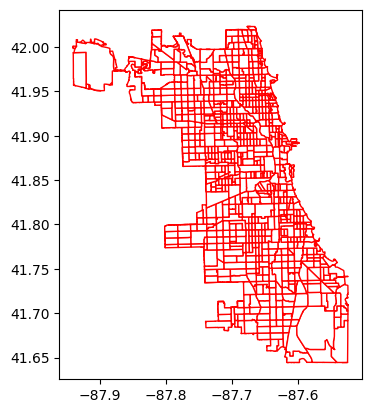

In [21]:
branchCopy = gpd.GeoDataFrame(
     branchCopy, geometry=gpd.points_from_xy(branchCopy.Longitude, branchCopy.Latitude), crs="EPSG:3435")

base = censusTracts.plot(color='white', edgecolor='red')


<Axes: title={'center': 'Raw Score of overlapping coverage'}>

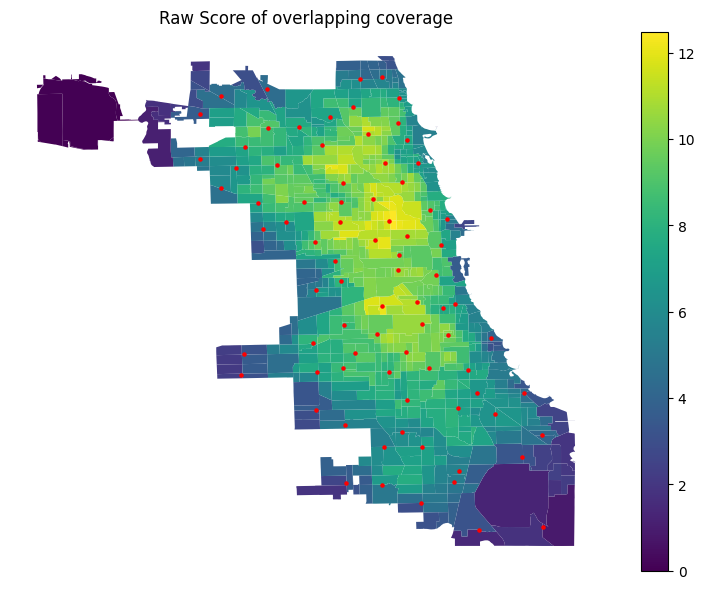

In [22]:
ax = censusTracts.plot(column = 'score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score of overlapping coverage")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Percent of access to at least one library'}>

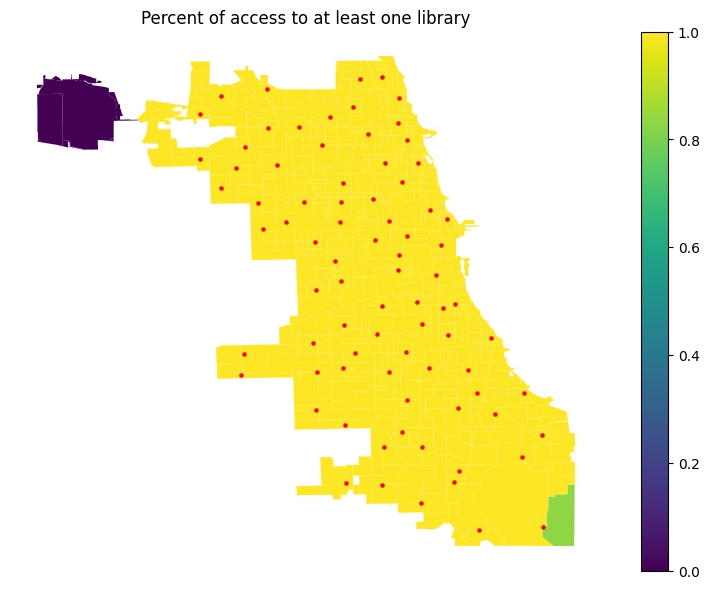

In [23]:
ax = censusTracts.plot(column = 'score norm', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of access to at least one library")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Percent of access to at least one library'}>

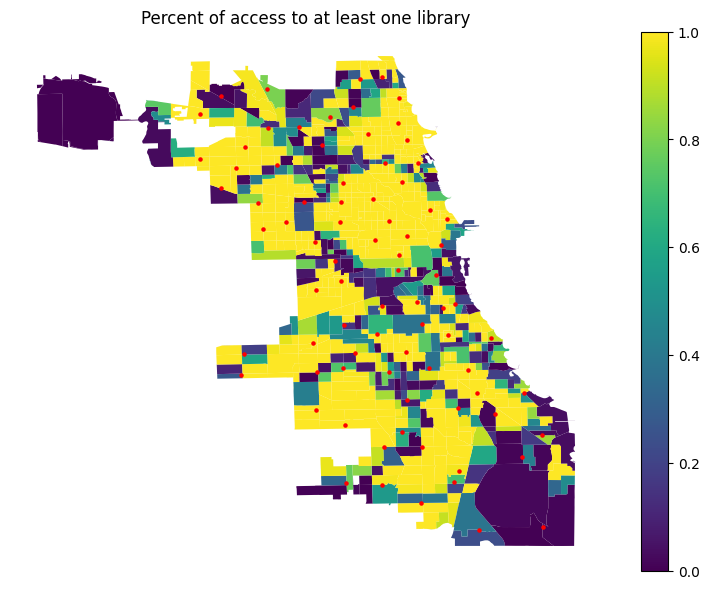

In [24]:
ax = censusTracts.plot(column = 'percent covered by at least one library', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of access to at least one library")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)
